In [5]:
import datetime
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchkeras import summary

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [6]:
# 导入数据
train_set = pd.read_csv('preprocessed_data/train_set.csv')
val_set = pd.read_csv('preprocessed_data/val_set.csv')
test_set = pd.read_csv('preprocessed_data/test.csv')

In [7]:
train_set.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,0.0,0.000381,0.000473,0.000000,0.009449,0.082147,0.004825,0.003656,0.040447,0.0,...,166,116,2,14,0,0,60,27,327,0
1,0.0,0.000127,0.000000,0.000000,0.075768,0.000000,0.000000,0.000000,0.000710,0.0,...,145,0,0,1166,0,1,469,0,0,0
2,0.0,0.000381,0.000236,0.137931,0.004804,0.030185,0.007841,0.062157,0.024126,0.0,...,99,0,0,588,0,11,434,0,0,0
3,0.0,0.011696,0.000473,0.034483,0.002180,0.000000,0.000000,0.032907,0.003193,0.0,...,188,34,1,862,0,0,67,27,380,1
4,0.0,0.004450,0.001064,0.034483,0.006119,0.039457,0.001206,0.009141,0.000887,0.0,...,348,0,0,296,0,9,23,0,0,0


In [8]:
# 需要将特征分成数值型和离散型
# 因为后面的模型里面离散型的特征需要embedding，而数值型的特征直接进入stacking层，处理方式不一样
data_df=pd.concat((train_set,val_set,test_set))

dense_feas=['I'+str(i) for i in range(1,14)]
sparse_feas=['C'+str(i) for i in range(1,27)]

# 定义一个稀疏矩阵的embedding映射，字典{key:value}，key表示每个稀疏特征，value表示数据集data_df对应列的不同取值个数
sparse_feas_map={}
for key in sparse_feas:
    sparse_feas_map[key]=data_df[key].nunique()

In [9]:
# 封装特征信息，建立模型的时候作为参数传入
feature_info=[dense_feas, sparse_feas, sparse_feas_map]

### 准备数据

数据构建成数据管道的好处：
1. 批量处理：数据管道允许你将数据分批次（batches）加载，这使得内存使用更加高效，并且可以并行处理数据，从而加快训练速度。
2. 打乱数据：在训练数据加载器（DataLoader）中设置 shuffle=True 可以确保每个epoch中的数据是随机打乱的，这有助于模型学习到更一般化的特征，而不是记住特定的数据顺序。
3. 易于实现数据增强：在数据管道中，你可以轻松地添加数据增强或预处理步骤，如归一化、标准化、裁剪等，这些都可以在加载数据时自动完成。

In [10]:
# 把数据构建成数据管道

# 1. 创建训练和验证的TensorDataset对象
dl_train_dataset=TensorDataset(torch.tensor(train_set.drop(columns='Label').values).float(),torch.tensor(train_set['Label']).float())
dl_val_dataset=TensorDataset(torch.tensor(val_set.drop(columns='Label').values).float(),torch.tensor(val_set['Label']).float())

# 2. 创建DataLoader对象
# DataLoader(dl_train_dataset, shuffle=True, batch_size=16)：创建一个 DataLoader 对象，用于以批次的方式加载 dl_train_dataset。设置 shuffle=True 表示在每个 epoch 开始时打乱数据，batch_size=16 表示每个批次包含 16 个样本。
dl_train=DataLoader(dl_train_dataset, shuffle=True, batch_size=16)
dl_valid=DataLoader(dl_val_dataset, shuffle=True, batch_size=16)

In [11]:
# 查看数据
for b in iter(dl_train):
    print(b[0].shape,b[1])
    break

torch.Size([16, 39]) tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.])


### 建立模型

In [12]:
# 定义一个全连接层的神经网络
class DNN(nn.Module):
    def __init__(self,hidden_units,dropout=0.):
        """
        hidden_units: 列表，每个元素表示每一层的神经网络个数，比如[256,128,64]表示两层网络，第一个256为输入维度，第二个表示神经单元128个，第三个表示第二层64个
        dropout：失活率
        """
        super(DNN,self).__init__()
        
        # 创建深层网络的代码
        self.dnn_network=nn.ModuleList([nn.Linear(layer[0],layer[1]) for layer in list(zip(hidden_units[:-1],hidden_units[1:]))])
        self.dropout=nn.Dropout(p=dropout)
        
    # 前向传播，需要遍历dnn_network
    def forward(self,x):
        for linear in self.dnn_network:
            x=linear(x)
            x=F.relu(x)
        x=self.dropout(x)
        
        return x

In [13]:
# 测试该网络
hidden_units=[16,8,4,2,1] # 层数和每一层神经单元个数
dnn=DNN(hidden_units)
summary(dnn,input_shape=(16,))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 8]                  136
Linear-2                                     [-1, 4]                   36
Linear-3                                     [-1, 2]                   10
Linear-4                                     [-1, 1]                    3
Dropout-5                                    [-1, 1]                    0
Total params: 185
Trainable params: 185
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000061
Forward/backward pass size (MB): 0.000122
Params size (MB): 0.000706
Estimated Total Size (MB): 0.000889
--------------------------------------------------------------------------


'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nLinear-1                                     [-1, 8]                  136\nLinear-2                                     [-1, 4]                   36\nLinear-3                                     [-1, 2]                   10\nLinear-4                                     [-1, 1]                    3\nDropout-5                                    [-1, 1]                    0\n==========================================================================\nTotal params: 185\nTrainable params: 185\nNon-trainable params: 0\n--------------------------------------------------------------------------\nInput size (MB): 0.000061\nForward/backward pass size (MB): 0.000122\nParams size (MB): 0.000706\nEstimated Total Size (MB): 0.000889\n-------------------------------------------

描述了一个神经网络模型的结构和参数统计信息。列出了模型中的各个层（Layer），每层的输出形状（Output Shape），以及每层的参数数量（Param）。
1. Layer：描述了网络中每一层的类型，在这个例子中输出了Linear（线性层）和Dropout。
2. Output Shape：显示了每一层的输出形状。在神经网络中，"[-1, x]" 通常表示批次大小（batch size）是可变的，而 "x" 表示该层输出的特征数量。例如，"[-1, 8]" 表示该层输出一个特征数为8的向量，批次大小不固定。
3. Param#：每一层的参数数量。
4. Total Params：模型中所有可训练参数的总数。
5. Trainable params：模型中所有可训练参数的数量，包括权重和偏置。
6. Non-trainable params: 这是模型中不可训练参数的数量，通常为0，表示所有参数都是可训练的。
7. Input size(MB): 这是模型输入数据的大小，以MB（兆字节）为单位。

In [14]:
class ProductLayer(nn.Module):
    
    def __init__(self, mode, embed_dim, field_num, hidden_units):
        
        super(ProductLayer, self).__init__()
        self.mode = mode
        # product层， 由于交叉这里分为两部分， 一部分是单独的特征运算， 也就是上面结构的z部分， 一个是两两交叉， p部分， 而p部分还分为了内积交叉和外积交叉
        # 所以， 这里需要自己定义参数张量进行计算
        # z部分的w， 这里的神经单元个数是hidden_units[0], 上面我们说过， 全连接层的第一层神经单元个数是hidden_units[1]， 而0层是输入层的神经
        # 单元个数， 正好是product层的输出层  关于维度， 这个可以看在博客中的分析
        self.w_z = nn.Parameter(torch.rand([field_num, embed_dim, hidden_units[0]]))
        
        # p部分, 分内积和外积两种操作
        if mode == 'in':
            self.w_p = nn.Parameter(torch.rand([field_num, field_num, hidden_units[0]]))
        else:
            self.w_p = nn.Parameter(torch.rand([embed_dim, embed_dim, hidden_units[0]]))
        
        self.l_b = torch.rand([hidden_units[0], ], requires_grad=True)
    
    def forward(self, z, sparse_embeds):
        # lz部分
        l_z = torch.mm(z.reshape(z.shape[0], -1), self.w_z.permute((2, 0, 1)).reshape(self.w_z.shape[2], -1).T)# (None, hidden_units[0])
        
        # lp 部分
        if self.mode == 'in':  # in模式  内积操作  p就是两两embedding先内积得到的[field_dim, field_dim]的矩阵
            p = torch.matmul(sparse_embeds, sparse_embeds.permute((0, 2, 1)))  # [None, field_num, field_num]
        else:  # 外积模式  这里的p矩阵是两两embedding先外积得到n*n个[embed_dim, embed_dim]的矩阵， 然后对应位置求和得到最终的1个[embed_dim, embed_dim]的矩阵
            # 所以这里实现的时候， 可以先把sparse_embeds矩阵在field_num方向上先求和， 然后再外积
            f_sum = torch.unsqueeze(torch.sum(sparse_embeds, dim=1), dim=1)  # [None, 1, embed_dim]
            p = torch.matmul(f_sum.permute((0, 2,1)), f_sum)     # [None, embed_dim, embed_dim]
        
        l_p = torch.mm(p.reshape(p.shape[0], -1), self.w_p.permute((2, 0, 1)).reshape(self.w_p.shape[2], -1).T)  # [None, hidden_units[0]]
        
        output = l_p + l_z + self.l_b
        return output

In [22]:
# 下面我们定义真正的PNN网络
# 这里的逻辑是底层输入（类别型特征) -> embedding层 -> product 层 -> DNN -> 输出
class PNN(nn.Module):
    
    def __init__(self, feature_info, hidden_units, mode='in', dnn_dropout=0., embed_dim=10, outdim=1):
        """
        DeepCrossing：
            feature_info: 特征信息（数值特征， 类别特征， 类别特征embedding映射)
            hidden_units: 列表， 全连接层的每一层神经单元个数， 这里注意一下， 第一层神经单元个数实际上是hidden_units[1]， 因为hidden_units[0]是输入层
            dropout: Dropout层的失活比例
            embed_dim: embedding的维度m
            outdim: 网络的输出维度
        """
        super(PNN, self).__init__()
        self.dense_feas, self.sparse_feas, self.sparse_feas_map = feature_info
        self.field_num = len(self.sparse_feas)
        self.dense_num = len(self.dense_feas)
        self.mode = mode
        self.embed_dim = embed_dim
        
         # embedding层， 这里需要一个列表的形式， 因为每个类别特征都需要embedding
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(key): nn.Embedding(num_embeddings=val, embedding_dim=self.embed_dim)
            for key, val in self.sparse_feas_map.items()
        })
        
        # Product层
        self.product = ProductLayer(mode, embed_dim, self.field_num, hidden_units)
        
        # dnn 层
        hidden_units[0] += self.dense_num
        self.dnn_network = DNN(hidden_units, dnn_dropout)
        self.dense_final = nn.Linear(hidden_units[-1], 1)
    
    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :13], x[:, 13:]   # 数值型和类别型数据分开
        sparse_inputs = sparse_inputs.long()      # 需要转成长张量， 这个是embedding的输入要求格式
        sparse_embeds = [self.embed_layers['embed_'+key](sparse_inputs[:, i]) for key, i in zip(self.sparse_feas_map.keys(), range(sparse_inputs.shape[1]))]   
        # 上面这个sparse_embeds的维度是 [field_num, None, embed_dim] 
        sparse_embeds = torch.stack(sparse_embeds)
        sparse_embeds = sparse_embeds.permute((1, 0, 2))   # [None, field_num, embed_dim]  注意此时空间不连续， 下面改变形状不能用view，用reshape
        z = sparse_embeds
        
        # product layer
        sparse_inputs = self.product(z, sparse_embeds)
        
        # 把上面的连起来， 注意此时要加上数值特征
        l1 = F.relu(torch.cat([sparse_inputs, dense_inputs], axis=-1))
        # dnn_network
        dnn_x = self.dnn_network(l1)
        
        outputs = F.sigmoid(self.dense_final(dnn_x))
        
        outputs=outputs.squeeze(1)
        
        return outputs 

In [23]:
hidden_units = [256, 128, 64]
hidden_units_copy = hidden_units.copy()
net = PNN(feature_info, hidden_units, mode='in')
summary(net, input_shape=(train_set.shape[1],))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                 [-1, 10]                  790
Embedding-2                                 [-1, 10]                2,520
Embedding-3                                 [-1, 10]               12,930
Embedding-4                                 [-1, 10]               10,430
Embedding-5                                 [-1, 10]                  300
Embedding-6                                 [-1, 10]                   70
Embedding-7                                 [-1, 10]               11,640
Embedding-8                                 [-1, 10]                  390
Embedding-9                                 [-1, 10]                   20
Embedding-10                                [-1, 10]                9,080
Embedding-11                                [-1, 10]                9,260
Embedding-12                         

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nEmbedding-1                                 [-1, 10]                  790\nEmbedding-2                                 [-1, 10]                2,520\nEmbedding-3                                 [-1, 10]               12,930\nEmbedding-4                                 [-1, 10]               10,430\nEmbedding-5                                 [-1, 10]                  300\nEmbedding-6                                 [-1, 10]                   70\nEmbedding-7                                 [-1, 10]               11,640\nEmbedding-8                                 [-1, 10]                  390\nEmbedding-9                                 [-1, 10]                   20\nEmbedding-10                                [-1, 10]                9,080\nEmbedding-11          

In [24]:
# 测试一下模型
for fea, label in iter(dl_train):
    print(fea.shape, label.shape)
    out=net(fea)
    print(out)
    break

torch.Size([16, 39]) torch.Size([16])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7772, 1.0000, 1.0000, 1.0000],
       grad_fn=<SqueezeBackward1>)


### 模型的训练

In [25]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred=y_pred.data
    y=y_true.data
    return roc_auc_score(y,pred) # 计算AUC 但要注意如果y只有一个类别的时候会报错

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001)
metric_func = auc
metric_name = 'auc'

In [26]:
epochs = 6
log_step_freq = 10

dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print('Start Training...')
nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print('========='*8 + "%s" %nowtime)

for epoch in range(1, epochs+1):
    # 训练阶段
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = net(features)
        loss = loss_func(predictions, labels)
        try:          # 这里就是如果当前批次里面的y只有一个类别， 跳过去
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    
    # 验证阶段
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')

Start Training...
========================================================================2024-09-12 19:54:23
[step = 10] loss: 9.932, auc: 0.535
[step = 20] loss: 5.925, auc: 0.543
[step = 30] loss: 4.340, auc: 0.577
[step = 40] loss: 3.495, auc: 0.562
[step = 50] loss: 2.965, auc: 0.543
[step = 60] loss: 2.582, auc: 0.546
[step = 70] loss: 2.306, auc: 0.530
[step = 80] loss: 2.109, auc: 0.533
[step = 90] loss: 1.960, auc: 0.540

EPOCH = 1, loss = 1.960,auc  = 0.540, val_loss = 0.674, val_auc = 0.417

================================================================================2024-09-12 19:54:28
[step = 10] loss: 0.679, auc: 0.487
[step = 20] loss: 0.607, auc: 0.563
[step = 30] loss: 0.625, auc: 0.578
[step = 40] loss: 0.668, auc: 0.537
[step = 50] loss: 0.691, auc: 0.565
[step = 60] loss: 0.671, auc: 0.556
[step = 70] loss: 0.673, auc: 0.539
[step = 80] loss: 0.686, auc: 0.535
[step = 90] loss: 0.682, auc: 0.538

EPOCH = 2, loss = 0.682,auc  = 0.538, val_loss = 0.586, val_auc = 0

出现报错：说明labels的尺寸是[16]，predictions的尺寸是[16,1]<br>
Eg：<br>
labels = torch.tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])<br>
predictions = torch.tensor([[0.2], [0.8], [0.1], [0.9], [0.3], [0.7], [0.15], [0.85], [0.25], [0.75], [0.2], [0.8], [0.1], [0.9], [0.3], [0.7]])<br>
<br>
<br>
当利用squeeze(1)来对张量进行操作时，结果如下：<br>
predictions = torch.tensor([[0.2], [0.8], [0.1], [0.9], [0.3], [0.7], [0.15], [0.85], [0.25], [0.75], [0.2], [0.8], [0.1], [0.9], [0.3], [0.7]])<br>
predictions = predictions.squeeze(1)<br>
tensor([0.2, 0.8, 0.1, 0.9, 0.3, 0.7, 0.15, 0.85, 0.25, 0.75, 0.2, 0.8, 0.1, 0.9, 0.3, 0.7])

In [ ]:
epochs = 6
log_step_freq = 10

dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print('Start Training...')
nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print('========='*8 + "%s" %nowtime)

for epoch in range(1, epochs+1):
    # 训练阶段
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = net(features)
        loss = loss_func(predictions, labels)
        try:          # 这里就是如果当前批次里面的y只有一个类别， 跳过去
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    
    # 验证阶段
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')

Start Training...
========================================================================2024-09-12 19:54:23
[step = 10] loss: 9.932, auc: 0.535
[step = 20] loss: 5.925, auc: 0.543
[step = 30] loss: 4.340, auc: 0.577
[step = 40] loss: 3.495, auc: 0.562
[step = 50] loss: 2.965, auc: 0.543
[step = 60] loss: 2.582, auc: 0.546
[step = 70] loss: 2.306, auc: 0.530
[step = 80] loss: 2.109, auc: 0.533
[step = 90] loss: 1.960, auc: 0.540

EPOCH = 1, loss = 1.960,auc  = 0.540, val_loss = 0.674, val_auc = 0.417

================================================================================2024-09-12 19:54:28
[step = 10] loss: 0.679, auc: 0.487
[step = 20] loss: 0.607, auc: 0.563
[step = 30] loss: 0.625, auc: 0.578
[step = 40] loss: 0.668, auc: 0.537
[step = 50] loss: 0.691, auc: 0.565
[step = 60] loss: 0.671, auc: 0.556
[step = 70] loss: 0.673, auc: 0.539
[step = 80] loss: 0.686, auc: 0.535
[step = 90] loss: 0.682, auc: 0.538

EPOCH = 2, loss = 0.682,auc  = 0.538, val_loss = 0.586, val_auc = 0

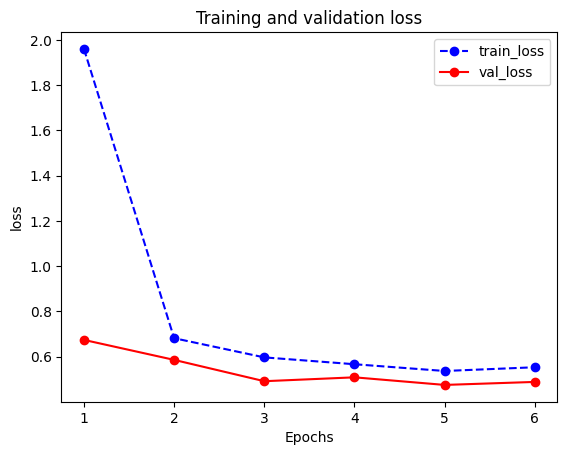

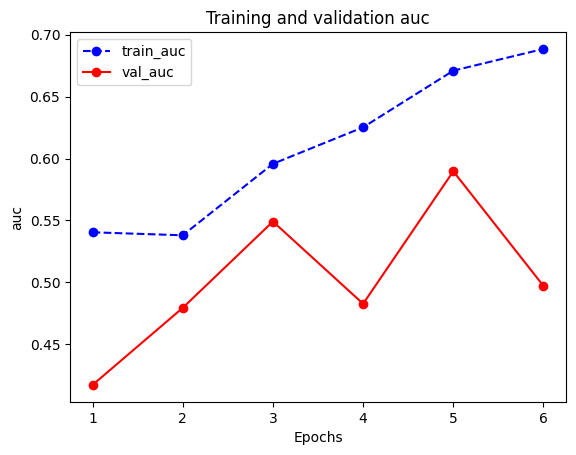

In [27]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [28]:
# 预测
y_pred_probs = net(torch.tensor(test_set.values).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [29]:
y_pred

tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 

In [34]:
y_pred=pd.DataFrame(y_pred)
prediction=y_pred.to_csv('output/prediction.csv',index=False)